# Imports

In [2]:
import pydot
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from keras.layers import dot
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Dataset

In [6]:
%%time 
dataset = pd.read_csv('../data/processed_data/active_users_df.csv')
#dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

CPU times: user 50.3 s, sys: 35.8 s, total: 1min 26s
Wall time: 1min 39s


In [15]:
# 50K rows from dataset
dataset_50 = dataset.sample(frac=0.001, random_state=42)

In [ ]:
# 500K rows from dataset
dataset_500 = dataset.sample(frac=0.01, random_state=42)

In [ ]:
# 5M rows from dataset
dataset_5M = dataset.sample(frac=0.1, random_state=42)

In [11]:
dataset.shape

(56738161, 3)

In [9]:
dataset.anime_id.nunique()

17172

In [10]:
dataset.user_id.nunique()

177913

# Order dataset by user_id and anime_id

In [12]:
anime_id_to_new_id = dict()
id = 1

In [14]:
dataset = dataset_50

NameError: name 'dataset_20' is not defined

In [13]:
%%time
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])


KeyboardInterrupt: 

In [11]:
%%time
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])


CPU times: user 1min, sys: 19 ms, total: 1min
Wall time: 1min


In [12]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 12106
Number of users 4035


In [13]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


In [14]:
dataset.rating = dataset.rating.astype(float)

# Neural network with MF 

## MF + Multilayer model

In [15]:
# Matrix factorization
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
from keras.layers import dot
prod = dot([anime_vec, user_vec], axes=1, normalize=False)

2021-08-28 13:13:10.771549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-28 13:13:10.771688: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-28 13:13:10.771739: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-28 13:13:10.772463: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Adding NN upon MF

prod_dropout = Dropout(0.2)(prod)
fc_1 = Dense(100, name='fc-1', activation='relu')(prod)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, anime_input], fc_3)
model.compile(optimizer=Adam(lr=0.1), loss = 'mean_squared_error')

/home/ka_wagon/.pyenv/versions/anime_map/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


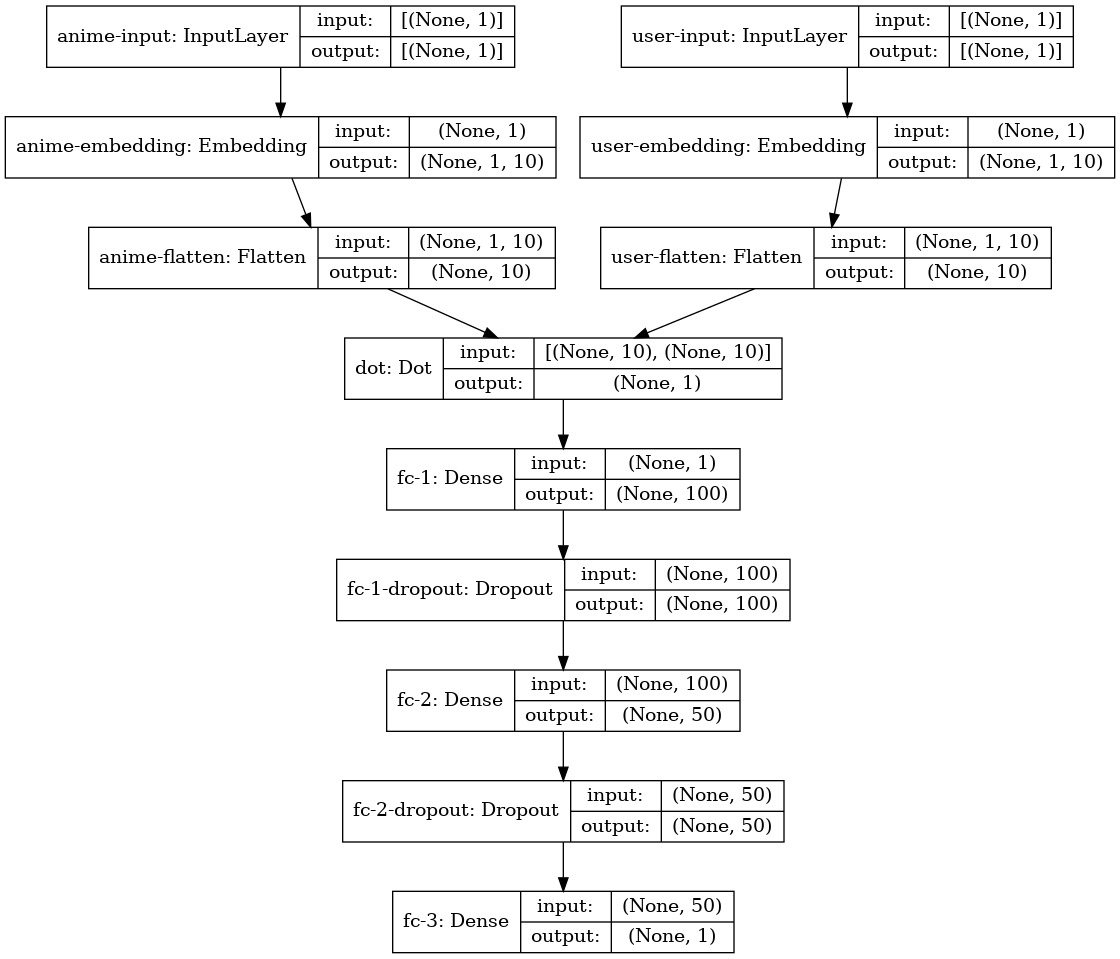

In [17]:
plot_model(model, show_shapes=True)

In [18]:
%%time
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=5)

2021-08-28 13:13:11.404694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
20561/20561 [==============================] - 88s 4ms/step - loss: 3.1684
Epoch 2/5
20561/20561 [==============================] - 88s 4ms/step - loss: 3.1447
Epoch 3/5
20561/20561 [==============================] - 90s 4ms/step - loss: 3.1189
Epoch 4/5
20561/20561 [==============================] - 93s 5ms/step - loss: 3.1178
Epoch 5/5
20561/20561 [==============================] - 93s 5ms/step - loss: 3.1176
CPU times: user 14min 21s, sys: 3min 10s, total: 17min 31s
Wall time: 7min 32s


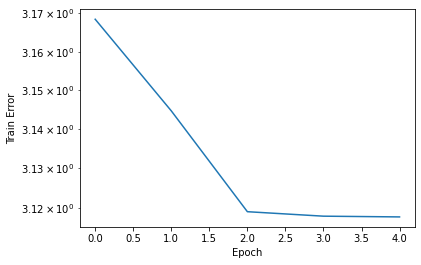

1.3667401224863975

In [19]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)